In [1]:
import numpy as np
from numpy import sin,cos,exp,tan,log,log10

import scipy as s
from scipy.integrate import odeint
from scipy import pi

import matplotlib.pyplot as plt

import os
import time
import inspect


# NOTE: magnetic moment is fixed in direction //z

# NOTE: currently, this simulation NEGLECTS SELF INDUCTANCE of the tube
# it was previously concluded that its effects are small for realistic choice of parameters
# this resulted from Mathematica simulations, it should be also incorporated here
# and the magnitude of its effects verified once more





In [2]:
# all adjustments should be required only in this cell, above the "-----------" line
# exceptions are naming of files - should be automated later! (can surely be...) - need to manually write correct
# templates for "...".format(...) files in the next cell, in the section concerned with storing data

# physical parameters

reduce_g = 1 # reduce g in order to see radial oscillations in a shorter tube with shorter time !!!
g = reduce_g * 9.81   # gravity acceleration (N/kg)

a = 0.05   # radius of tube (m)
H = 1  # length of tube (m)
h = 0.01   # thickness of tube (m)
sigma = 5.92e7   # conductivity of tube material (Siemens)
mu = 4*pi*1e-7   # magnetic permeability
m = 2   # dipole moment (A/m^2)
M = 0.0030   # mass of magnet (kg)



# simulation parameters
t_max = 2
max_iter = 2000   # total number of iterations in time
dt = t_max/max_iter

init_height = 0.0*H # setting the initial condition z[0]
init_displ = 0 # setting the initial condition x[0]

N = 200  # number of ring partitions of tube
dH = H/N   # height of one ring
R = 2*pi*a/(sigma*h*dH)   # resistance of one ring (Ohm)
Z_ring = -(np.arange(N)+1/2) * dH   # array that stores effective positions of rings (midpoints in z)
#print(Z_ring)




# initiate arrays that store our data

T = np.linspace(0,t_max,max_iter)   # array that stores all points in time 

z = np.zeros((max_iter))   # array that stores coordinates of magnet along axes as time progresses
vz = np.zeros((max_iter))
az = np.zeros((max_iter))

x = np.zeros((max_iter))   # array that stores radial coordinates of magnet in x-z plane as time progresses
vx = np.zeros((max_iter))
ax = np.zeros((max_iter))

J = np.zeros((max_iter, N))  # array that stores currents (in Amperes) in all rings as time progresses
Fx = np.zeros((max_iter, N)) # array that stores lateral forces (in Newtons) in all rings as time progresses
Fz = np.zeros((max_iter, N)) # array that stores vertical forces (in Newtons) in all rings as time progresses






# file storage settings - this will be used in code below/next cell, when performing the data storage after simulation

folder = "python_arrays_offaxis"
seed = 1  # parameter to create file name (it starts with this integer number)
# relevant values of seed:
# 1 - initial few investigations

# now create simulation-specific subfolder in "folder" so that path = folder/"subfolder"
path = os.path.join(folder,  '{}_N{}_iter{}_t{}_x{}'.format(seed,  N, max_iter, t_max, init_displ))
print(path)
os.mkdir(path)

# these lists contain info about which variables to store in which ways (more below/next cell)
stored_arrays = [x,vx,z,vz,J]
variables = [reduce_g,g,a,H,h,sigma,mu,m,M]
settings = [t_max,max_iter,dt,init_height,init_displ,N,dH,R,folder,seed]




#----------------------------------------------------------------------------------------


def emf(x,z,vz):
    """This function calculates the e.m.f. by doing integral "v cross B" along the body of the ring, neglecting the vx component
    of motion, which is much smaller than vz component."""
    v = z/a
    u = x/a
    integral =  s.integrate.quad(lambda phi: v * (1 - u*cos(phi)) / (1 + u**2 - 2*u*cos(phi) + v**2)**(5/2), 0, 2*pi )
    integral = integral[0]
    integral *= - 3 * mu/4/pi * m * vz / a**2
    return integral


def force_z(x,z,J):
    """Magnetic force of an elemental ring in z-direction, argument z interpreted as z(magnet) - z_ring"""
    u = x/a
    v = z/a
    integral = s.integrate.quad(lambda phi: v * (1 - u*cos(phi)) / (1 + u**2 + v**2 - 2*u*cos(phi))**(5/2), 0, 2*pi)
    integral = integral[0]
    integral *= + 3 * mu/4/pi * m / a**2 * J
    return integral
    
def force_x(x,z,J):
    """Magnetic force of an elemental ring in x-direction, argument z interpreted as z(magnet) - z_ring"""
    u = x/a
    v = z/a
    integral = s.integrate.quad(lambda phi: cos(phi) * (1 + u**2  - 2*v**2 - 2*u*cos(phi)) / (1 + u**2  + v**2 - 2*u*cos(phi))**(5/2), 0, 2*pi)
    integral = integral[0]
    integral *= +  mu/4/pi * m / a**2 * J
    return integral


python_arrays_offaxis/1_N200_iter2000_t2_x0


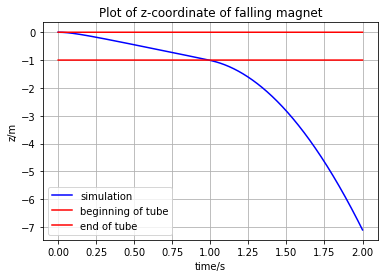

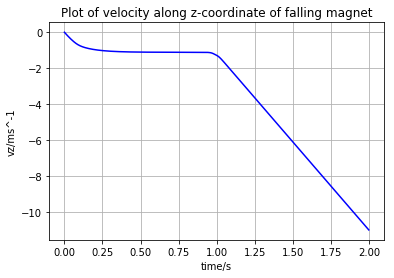

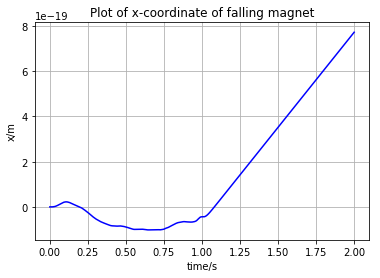

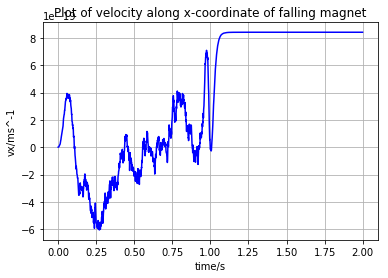

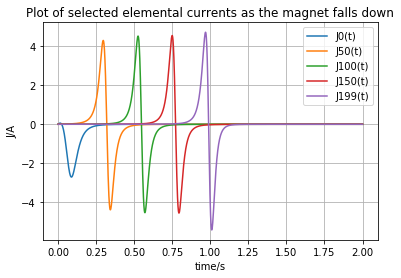

final coordinate of magnet, in cm: -710.24
and in case of free fall, in cm:   -1962.00

simulation took 165.26 s


In [3]:


# now implement ICs to get values for first two iterations

z[0] = init_height
az[0] = -g
vz[0] = 1/2*dt*az[0] # vz[0] is in fact vz[1/2], all indices for velocity are shifted forwards by 1/2
z[1] = z[0] + vz[0]*dt

x[0] = init_displ
ax[0] = 0
vx[0] = 1/2*dt*ax[0] # vx[0] is in fact vx[1/2], all indices for velocity are shifted forwards by 1/2
x[1] = x[0] + vx[0]*dt

J[0,:] = 0
J[1,:] = 1/R * emf(x[1],z[1],vz[0]+1/2*dt*az[0])  # use extrapolated velocity between V[1/2] and V[3/2] to approximate V[1]



# solve using a finite difference approach "x[t+dt] = x[t] + dt*x'[t+1/2*dt]"

sim_start = time.time()

for i in range(1,max_iter-1):
        
    for n in range(N):  # quite stupid way, should later vectorize, but probably would not make much difference,
                        # as looping is likely negligible compared to all these horrible numerical integrations
        Fx[i,n] = force_x(x[i], z[i]-Z_ring[n], J[i,n])
        Fz[i,n] = force_z(x[i], z[i]-Z_ring[n], J[i,n])
        
    ax[i] = 1/M * sum(Fx[i,:])   # sum all forces corresponding to separate rings at iteration i
    az[i] = -g + 1/M * sum(Fz[i,:])
    
    vx[i] = vx[i-1] + ax[i]*dt   # e.g. for i=1: V[3/2] = V[1/2] + A[1]*dt
    vz[i] = vz[i-1] + az[i]*dt   # e.g. for i=1: V[3/2] = V[1/2] + A[1]*dt
    
    x[i+1] = x[i] + vx[i]*dt   # e.g. for i=1: Z[2] = Z[1] + V[3/2]*dt
    z[i+1] = z[i] + vz[i]*dt   # e.g. for i=1: Z[2] = Z[1] + V[3/2]*dt
    
    for n in range(N):
        J[i+1,n] = 1/R * emf(x[i+1], z[i+1]-Z_ring[n],vz[i]+1/2*dt*az[i]) # e.g. for i=1: J[2] = f( Z[2], V[3/2]+A[2]*1/2*dt )

sim_end = time.time()    
    
    
    
# plot graphs showing the important quantities schematically    
    
plt.plot(T,z,'b',label='simulation')
#plt.plot(T,init_height-1/2*g*T**2,'g',label='free fall')
plt.plot(T, 0*np.ones(max_iter),'r', label='beginning of tube')
plt.plot(T, -H*np.ones(max_iter),'r', label='end of tube')
plt.legend()
plt.xlabel('time/s')
plt.ylabel('z/m')
plt.title('Plot of z-coordinate of falling magnet')
plt.grid()
plt.show()

plt.plot(T[:-1],vz[:-1],'b')
plt.xlabel('time/s')
plt.ylabel('vz/ms^-1')
plt.title('Plot of velocity along z-coordinate of falling magnet')
plt.grid()
plt.show()

plt.plot(T,x,'b',label='simulation')
plt.xlabel('time/s')
plt.ylabel('x/m')
plt.title('Plot of x-coordinate of falling magnet')
plt.grid()
plt.show()

plt.plot(T[:-1],vx[:-1],'b')
plt.xlabel('time/s')
plt.ylabel('vx/ms^-1')
plt.title('Plot of velocity along x-coordinate of falling magnet')
plt.grid()
plt.show()

for k in [0, N//4, N//2, 3*N//4, N-1]:
    plt.plot(T, J[:,k], label='J'+str(k)+'(t)')
plt.xlabel('time/s')
plt.ylabel('J/A')
plt.legend()
plt.title('Plot of selected elemental currents as the magnet falls down')
plt.grid()
plt.show()
    

    

    
# this section is concerned with creating files in which to store the outcomes

def retrieve_name(var):
    """https://stackoverflow.com/questions/18425225/getting-the-name-of-a-variable-as-a-string"""
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

# at the top of this notebook/file are settings like e.g.:
#stored arrays = [x,vx,z,vz,J,alpha,d1_alpha]
#variables = [reduce_g,g,a,H,h,sigma,mu,m,M,I]
#settings = [t_max,max_iter,dt,init_height,init_displ,init_angle,N,dH,R]

# save the data in separate files with arrays of corresponding physical quantities inside specific folder
# name of file is indicative of content (thought not exhaustive of all specifications), as below:

for array in stored_arrays:
    np.savetxt('{}/{}_{}_N{}_iter{}_t{}_x{}'.format(path, seed, retrieve_name(array)[0], N, max_iter, t_max, init_displ), array)

# and finally create a file with overall description of the simulation
infoFileName = '{}/{}_info_N{}_iter{}_t{}_x{}'.format(path, seed, N, max_iter, t_max, init_displ)

f = open(infoFileName, "w")
f.write("simulation run on "+str(time.asctime( time.localtime(time.time()) ))+'\n')
f.write("simulation took "+"{:.2f}".format(sim_end-sim_start)+" s"+'\n')
f.write('\n')
f.write("physical parameters:"+'\n')
for var in variables:
    f.write(retrieve_name(var)[0]+" = "+str(var)+'\n')
f.write('\n')
f.write("simulation parameters:"+'\n')
for setting in settings:
    f.write(retrieve_name(setting)[0]+" = "+str(setting)+'\n')
f.write("\n")
f.close()



# finally print out some last information

print("final coordinate of magnet, in cm:","{:.2f}".format(z[-1]*100))
print("and in case of free fall, in cm:  ","{:.2f}".format((init_height-1/2*g*T[-1]**2)*100))
print()
print("simulation took","{:.2f}".format(sim_end-sim_start),"s")


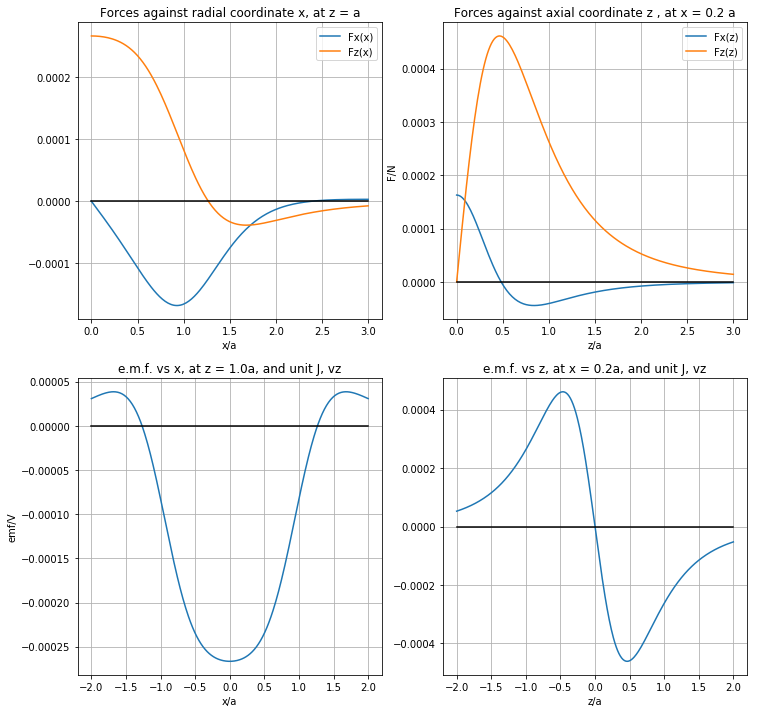

In [62]:
# investigate the spatial dependence of forces

gridlength = 200
X = np.linspace(0, 3*a, gridlength)
Z = np.linspace(0,3*a,gridlength)
x_fix = 0.2*a  # when investigating quantity(z) at x=const.
z_fix = 1*a    # when investigating quantity(x) at z=const.
J = 1  # fix current to be 1 Ampere
Fx_x, Fx_z, Fz_x, Fz_z = np.zeros(gridlength), np.zeros(gridlength), np.zeros(gridlength), np.zeros(gridlength)

for i in range(gridlength):
    Fx_x[i] = force_x(X[i], z_fix, J)
    Fx_z[i] = force_x(x_fix, Z[i], J)
    Fz_x[i] = force_z(X[i], z_fix, J)
    Fz_z[i] = force_z(x_fix, Z[i], J)

plt.figure(figsize=(12,12))
    
plt.subplot(2,2,1)
plt.plot(X/a, Fx_x, label="Fx(x)")
plt.plot(X/a, Fz_x, label="Fz(x)")
plt.plot(X/a, 0*X,'k')
plt.legend()
plt.grid()
plt.title("Forces against radial coordinate x, at z = a")
plt.xlabel('x/a')
#plt.ylabel('F/N')
#plt.show()

plt.subplot(2,2,2)
plt.plot(Z/a, Fx_z, label="Fx(z)")
plt.plot(Z/a, Fz_z, label="Fz(z)")
plt.plot(Z/a, 0*Z, 'k')
plt.legend()
plt.grid()
plt.title("Forces against axial coordinate z , at x = 0.2 a")
plt.xlabel('z/a')
plt.ylabel('F/N')
#plt.show()


# investigate the spatial dependence of d_phi_mag / d_z , which corresponds to e.m.f. for vz = 1 m/s

gridlength = 400
X = np.linspace(-2*a, 2*a, gridlength)
Z = np.linspace(-2*a,2*a,gridlength)
x_fix, z_fix = 0.2*a , 1*a
emf_x, emf_z = np.zeros(gridlength), np.zeros(gridlength)
J = 1

for i in range(gridlength):
    
    emf_x[i] = emf(X[i], z_fix, 1)
    emf_z[i] = emf(x_fix, Z[i], 1)

plt.subplot(2,2,3)
plt.plot(X/a, emf_x, label="emf(x)")
plt.plot(X/a, 0*X,'k')
#plt.legend()
plt.grid()
plt.title("e.m.f. vs x, at z = " + str("{:.1f}".format(z_fix/a)) + "a, and unit J, vz")
plt.xlabel('x/a')
plt.ylabel('emf/V')
#plt.show()

plt.subplot(2,2,4)
plt.plot(Z/a, emf_z, label="emf(z)")
plt.plot(Z/a, 0*Z,'k')
#plt.legend()
plt.grid()
plt.title("e.m.f. vs z, at x = " + str("{:.1f}".format(x_fix/a)) + "a, and unit J, vz")
plt.xlabel('z/a')
#plt.ylabel('emf/V')
#plt.show()

#plt.tight_layout()

plt.show()

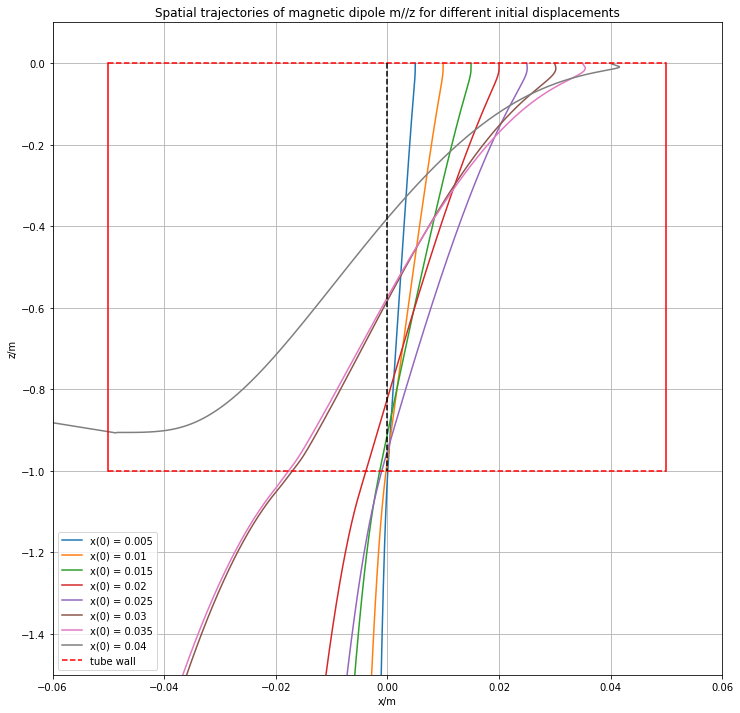

In [68]:
# this cell plots trajectories for multiple initial radial displacements x

init_displs = np.array([0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04])
X = np.zeros((len(init_displs), max_iter))
Z = np.zeros((len(init_displs), max_iter))

plt.figure(figsize=(12,12))
plt.title("Spatial trajectories of magnetic dipole m//z for different initial displacements")

for i, x0 in enumerate(init_displs):
    X[i,:] = np.genfromtxt("python_arrays_offaxis/1_N200_iter2000_t2_x{}/1_x_N200_iter2000_t2_x{}".format(x0, x0))
    Z[i,:] =np.genfromtxt("python_arrays_offaxis/1_N200_iter2000_t2_x{}/1_z_N200_iter2000_t2_x{}".format(x0, x0))
    plt.plot(X[i,:], Z[i,:], label="x(0) = "+str(x0))
    
plt.plot([-a,+a], [-H,-H],'r--', label='tube wall')
plt.plot([-a,+a], [0,0],'r--')
plt.plot([-a,-a], [0, -H], 'r')
plt.plot([+a,+a], [0, -H], 'r')
plt.plot([0,0], [0, -H], 'k--')
plt.xlabel('x/m')
plt.ylabel('z/m')
plt.ylim(-1.5,0.1)
plt.xlim(-0.06,0.06)
plt.legend()
plt.grid()
plt.show()



In [71]:
# find out the terminal velocity for this choice of parameters, for a very thin and very long tube (H -> inf)

vt = (1024 * a**4 * M * g) / (45 * mu**2 * h * sigma * m**2)
print(vt)

1.1193252382109613


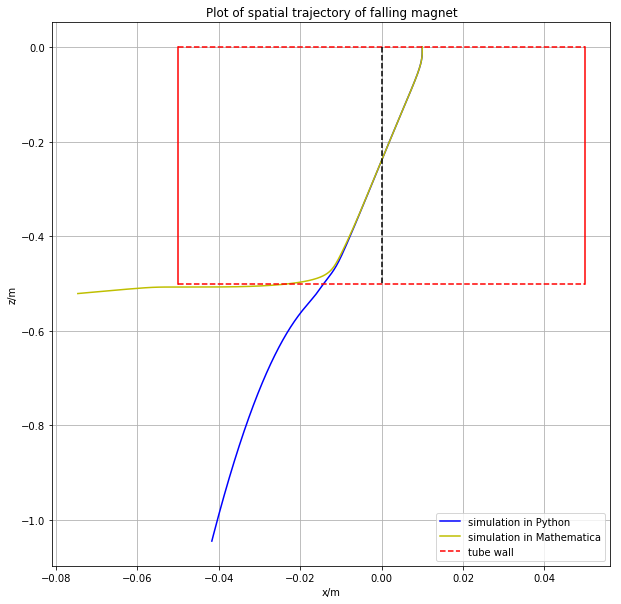

In [12]:
# this cell loads data for a Mathematica and a Python simulation 
# in order to plot trajectories of magnet in both simulations
# one should check that physical and simulation parameters agree!!!

# modify simulation parameters in filename, the file containing array
# with corresponding simulation is then loaded (if exists!)
X_py = np.genfromtxt("python_arrays/3_x_N100_iter3000_t3")
Z_py = np.genfromtxt("python_arrays/3_z_N100_iter3000_t3")

# likewise for Mathematica files
X_wm = np.genfromtxt("mathematica_arrays/sim1_U.dat")
Z_wm = np.genfromtxt("mathematica_arrays/sim1_Z.dat")

plt.figure(figsize=(10,10))
plt.plot(X_py, Z_py, 'b', label='simulation in Python')
plt.plot(X_wm, Z_wm, 'y', label='simulation in Mathematica')
plt.plot([-a,+a], [-H,-H],'r--', label='tube wall')
plt.plot([-a,+a], [0,0],'r--')
plt.plot([-a,-a], [0, -H], 'r')
plt.plot([+a,+a], [0, -H], 'r')
plt.plot([0,0], [0, -H], 'k--')
plt.xlabel('x/m')
plt.ylabel('z/m')
plt.legend()
plt.title('Plot of spatial trajectory of falling magnet')
plt.grid()
plt.show()

In [13]:
# discarded code

"""
# examination of motion as it changes with different number N of partitions of tube 

T = np.linspace(0,t_max,max_iter)   # array that stores all points in time 

x_N100 = np.loadtxt('python_arrays/1_x_N100_iter1500_t10')
x_N300 = np.loadtxt('python_arrays/1_x_N300_iter1500_t10')
x_N1000 = np.loadtxt('python_arrays/1_x_N1000_iter1500_t10')

plt.plot(T,x_N100, 'p', label='N = 100')
plt.plot(T,x_N300, 'b', label='N = 300')
plt.plot(T,x_N1000, 'g', label='N = 1000')
plt.legend()
plt.title('Comparision of x-motion for various number of ring partitions while keeping other parameters fixed')
plt.xlabel('time/s')
plt.ylabel('x/m')
plt.show()
"""

"\n# examination of motion as it changes with different number N of partitions of tube \n\nT = np.linspace(0,t_max,max_iter)   # array that stores all points in time \n\nx_N100 = np.loadtxt('python_arrays/1_x_N100_iter1500_t10')\nx_N300 = np.loadtxt('python_arrays/1_x_N300_iter1500_t10')\nx_N1000 = np.loadtxt('python_arrays/1_x_N1000_iter1500_t10')\n\nplt.plot(T,x_N100, 'p', label='N = 100')\nplt.plot(T,x_N300, 'b', label='N = 300')\nplt.plot(T,x_N1000, 'g', label='N = 1000')\nplt.legend()\nplt.title('Comparision of x-motion for various number of ring partitions while keeping other parameters fixed')\nplt.xlabel('time/s')\nplt.ylabel('x/m')\nplt.show()\n"

In [ ]:
"""

Notes on graphs:

e.g. N = 50
- this is manifested in number of "ripples" in vz graph, as the magnitude of force slightly varies as magnet falls w.r.t. centres of rings (current density as function of z is a delta comb with N spikes)
- these ripples are modulated by a wave with twice the frequency of radial oscillations - as for the evaluation of z-forces, it is the same whether the magnet is on +ve side with +/- velocity or on -ve side with -/+ velocity
- why is there such a huge noise in vx? i.e. what is the source of small ripples in x data?

- these concepts best seen in file "tube_off_axis-Copy6.ipynb"

"""

In [ ]:
"""
folder = 'python_arrays'
np.savetxt('{}/{}_x_N{}_iter{}_t{}'.format(folder, seed, N, max_iter, t_max), x)
np.savetxt('{}/{}_vx_N{}_iter{}_t{}'.format(folder, seed, N, max_iter, t_max), vx)
np.savetxt('{}/{}_z_N{}_iter{}_t{}'.format(folder, seed, N, max_iter, t_max), z)
np.savetxt('{}/{}_vz_N{}_iter{}_t{}'.format(folder, seed, N, max_iter, t_max), vz)
np.savetxt('{}/{}_J_N{}_iter{}_t{}'.format(folder, seed, N, max_iter, t_max), J)
"""

In [ ]:
"""
seed = 5  # parameter to create file name (it starts with this integer number)

# choice of word "seed" is derived from other programmes I have written
# where "seed" was actually a random number to distinguish otherwise same filenames
# "code" would perhaps be more appropriate here
#
# relevant values of "seed":
# 1 - initial few investigations
# 2 - began experimenting with reducing g
# 3 - simulations taken the week before end of summer presentation (mid-september 2020)
# 4 -
# 5 - equivalent trial no self-inductance
# 6 - equiv. trial with self-inductance
"""